# Welcome

In this notebook we are going to train our own [Deep Neural Network (DNN)](https://en.wikipedia.org/wiki/Deep_learning).

With our DNN we are going to be solving a [Categorical Classification](https://en.wikipedia.org/wiki/Statistical_classification) problem in the [Computer Vision](https://en.wikipedia.org/wiki/Computer_vision) domain.

This means that we will present an image of a face to our DNN and our DNN will predict whether this image is your face or a random other face.

This first step in training a DNN is making sure we have lots of high quality training data. Because collecting lots of images where the object/face is visible and lots of images where teh object/face is not visible is a lenghthy and boring task, we'll be using a couple of publically available datasets.
* We will download a dataset with lots of images of faces. These images will serve as the FACE class.
* We will download a second dataset with lots of images of object, scenes and animals to act as the NO-FACE class.

To make training easier we will use a ready-made state-of-the-art architecture for image classification called [Xception](https://arxiv.org/abs/1610.02357).

Finally we will download our DNN to our phones and run inference on a realtime camera feed using TensorFlowLite.


---


**Before we get started we will need to download the app to our phones**

iOS:
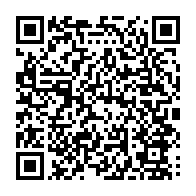
Android: 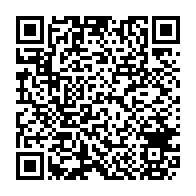


# Importing our libraries and frameworks

The first thing we need to do is import the libraries and frameworks that we are going to use.
* **Keras** -> High-level API to control TensorFlow (Deep Learning Library)
* **Matplotlib** -> Plotting library to visually inspect our input images
* **QRCode** -> Library for generating a QR-code


In [ ]:
!pip install qrcode > /dev/null
import tensorflow as tf
import matplotlib.pyplot as plt
import os, zipfile, qrcode, math, base64, IPython, requests, glob, json
from PIL import Image

# Downloading FACE and NO-FACE images

The first thing we will do is download our reference images which we will use as the NO-FACE class. We are downloading the images from a publically available dataset called [Common Objects In Context (COCO)](https://cocodataset.org/#home). This dataset contains lots of images of everyday objects and scenes. Some of the images also contain people. We remove these images since they might confuse our DNN.

The FACE images we will download from the [Labeled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) dataset. This dataset contains images of faces of different persons with different ethnicities and backgrounds.

In [ ]:
!rm -rf lfw val2017 data val2017.zip lfw.tgz annotations_trainval2017.zip annotations
!mkdir data

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip > /dev/null
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip > /dev/null

with open("annotations/person_keypoints_val2017.json", "r") as f:
  annotations = json.load(f)

for annotation in annotations["annotations"]:
  image_id = annotation["image_id"]
  file_name = next(x["file_name"] for x in annotations["images"] if x["id"] == image_id)
  if os.path.exists(f"val2017/{file_name}"):
    os.remove(f"val2017/{file_name}") 

!mv val2017 data/no-face

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar zxvf lfw.tgz > /dev/null

files = glob.glob(f"lfw/**/*.jpg")
os.mkdir("data/face")
amount = len(os.listdir("data/no-face"))
for file in files[:amount]:
  filename = os.path.basename(file)
  os.rename(file, f"data/face/{filename}")


# Creating our data loaders

While training, we are going to need to dynamically load the images that we are going to train on (because the whole dataset does not fit in memory in one go).

To do this we are going to use a Keras DataGenerator. This class will handle all the IO and preprocessing and batching for us. We are going to be working with batches of 128 images. This means we will train on 128 images at the same to to speed up te training process.

As you can see in the block below we are going to create two generators. The first generator contains the images that we are going to train our DNN on. The second generator contains our validation images. We will use the validation images to make sure our DNN is not overfitting. For this it is important that the training images and the validation images are kept strictly separate. The result on the validation images will give us an idea of how well our DNN can generalize to images it has never seen before.

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

print("Training data:")
train_gen = data_gen.flow_from_directory(
    "data",
    target_size=(224, 224),
    batch_size=32,
    subset="training"
)
print()

print("Validation data:")
val_gen = data_gen.flow_from_directory(
    "data",
    target_size=(224, 224),
    batch_size=32,
    subset="validation"
)

# Inspecting our input data

It is good practice to inspect our input data before we start training. This next block will show 25 images. Underneath each image we see the label of the class that this image belongs to.

These labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot). Which means that it is a list of integers of which only one is equal to '1'. The index of the '1' integer relates to the class this image belongs to. This means that if we have [1, 0] this image belongs to the first class (FACE) and if we have [0, 1] it belongs to the second class (NO-FACE).

In the figure below we will do a simple translation to make the class more readable. We will transform [1, 0] into FACE and [0, 1] into NO-FACE.

If there is something wrong with the way we load our input images we can instantly see it here.

In [ ]:
plt.figure(figsize=(10,10))
batch = train_gen.next()
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(batch[0][i], cmap=plt.cm.binary)
  true = "NO-FACE" if batch[1][i][1] else "FACE"
  plt.xlabel(true)
plt.show()

# Creating our DNN

To speed up training and it is often beneficial to employ a technique called [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning). Transfer Learning means that you take an already trained model, in this case Google's [Xception](https://arxiv.org/abs/1610.02357), and make it specific for your dataset.

The main advantange of using Transfer Learning is that you can get by with smaller datasets. Using Transfer Learning also speeds up training and means you do not have to make up your own model architecture.

We will take the pretrained base model and add our own final layers to it. We are going to add two different layers.
* A pooling layer
* A dense (fully-connected) layer with Softmax activation.


In [ ]:
base = tf.keras.applications.Xception(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
base.trainable = False
pool_layer = tf.keras.layers.GlobalAveragePooling2D()
predict_layer = tf.keras.layers.Dense(train_gen.num_classes, activation="softmax")
model = tf.keras.Sequential([base, pool_layer, predict_layer])
model.summary()


# Training our DNN on the input data

Now it is time to start the training. For training we are going to need two things.
* A loss function which is a mathematical function that determines how well our DNN is performing
* An optimizer that will incrementally improve the DNN by calculating which parameters need to be tweaked to lower the loss value. This is done using backpropagation. 

During training Keras will give us two metrics. The value of the loss and the accuracy of the DNN.
* The loss value is an arbirary value which indicates how well the DNN is performing (the lower the better)
* Since we are doing a classification task we can calculate the amount of correct predictions and divide that by the total amount of predictions. This will give us the accuracy, a percentage of correctly predicted images (between 0 and 1).

We will see both the loss and accuracy during training, as well as during validation. As mentioned before the validation images are used to see if our DNN is learning something and is able to generelize what it learned to images it has never seen before.

We are going to be training the DNN for 25 epochs. Each epoch has 25 training steps and each training step has 32 images. This means in total we will be training our DNN on 20,000 different images.

The validation metrics is what we are going to be looking at to see if the DNN is still learning. As long as the validation loss is still going down (or validation accuracy up) we know the DNN is still learning.

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=2e-5)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

model.fit(
    train_gen,
    epochs=25,
    steps_per_epoch=25,
    validation_data=val_gen,
    validation_steps=5
)

# Testing our DNN

A logical next step is to visually inspect whether our DNN is giving valid predictions. Next we will load some of the validation images and have our DNN predict whether there is a person or not in the image (remember our DNN has not seen the validation set during training and therefore we can use this subset for testing the DNN).

In practice the app that we are going to use does exactly the same as the following code, except for that it uses images that have been captured in realtime using the device's camera.

The output that the model will give of each image is an array of floating point values that add up to 1. These values are the confidences for each class. An example of an output could be [0.83, 0.17]. This means that the model is 83% confident the input image belongs to the class on the first index (which in our case is the FACE class). The higher the confidence is for a given class the more sure the model is that this image belongs to that respective class.

We will do a couple of transformations to our output to make it more readable. The output we will see below explains the prediction that the model has made. In the figure you will see a couple of things:
* The input image that is fed into the model.
* The prediction (either FACE or NO-FACE). 
* The confidence of the prediction (value between 0 and 1).

In [ ]:
plt.figure(figsize=(10,10))
batch = val_gen.next()
batch_y = model(batch[0])
batch_pred = tf.math.argmax(batch_y, axis=-1)
batch_prob = tf.math.reduce_max(batch_y, axis=-1)
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(batch[0][i], cmap=plt.cm.binary)
  pred = "NO-FACE" if batch_class[i] else "FACE"
  prob = tf.cast(batch_prob[i] * 100, tf.int32)
  plt.xlabel(f"{pred} ({prob}%)")
plt.show()

# Converting our DNN to TFLite format

Lastly we need to convert our DNN to the [TensorFlowLite](https://www.tensorflow.org/lite) format. This so we can use the DNN in the mobile app.

We will be transfering the model to our device using a temporary file server called [tmp.ninja](https://tmp.ninja). This next block will generate a QR-code that you can scan with the app to transfer the model file.



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
model_data = converter.convert()

files = {"files[]": model_data }
response = requests.post("https://tmp.ninja/upload.php?output=text", files=files)
file_info = response.json()["files"][0]
hash = file_info["hash"]
id = file_info["url"].split("/")[-1]

img = qrcode.make(f"ml-classification://model?id={id}&hash={hash}")
img.save("qr.png")
IPython.display.Image(open("qr.png","rb").read())

# What's Next?

Now that we have trained our own model we can start thinking about the next steps. Of course we want our model to make the best predictions as possible. There are two things we can work on to improve our model.

The first and most important one is the data. The better training data we have the our final model is going to be. The more variation there is in our data the better our model will be at generalizing to images it has never seen before. Not only quantity of data is important here but also the quality of the data.

The second thing we can work on is tweaking the hyperparameters and the model. We can change the architecture of the model or alter parameters such as the learning-rate, the optimizer and the loss function to improve the model. Remember that tweaks like this might take your model from 98% accuracy to 99% but if your training data and validation data is bad changing the architecture or hyperparameters is not going to make your model generalize better.

Another thing that we might try to do is make our model explain its predictions. Right now we have no idea why the model is classifying some images as FACE and others as NO-FACE. There are several methods that we can employ: 
* Ceating heatmaps which reveal areas of the image that contributed most to the prediction of the model.
* Looking at intermediate activations of the model to deduce features that the model looks at.
* Generating adverserial examples to see which types of images result in a high probability in one output class.
* Adding a explainer DNN to our predictor DNN that can describe what the prediction DNN is predicting.

# Testing without running the scripts

If you would like to test the app without training your own model you can download a pre-trained DNN right here. Just scan the following QR-code using the app.

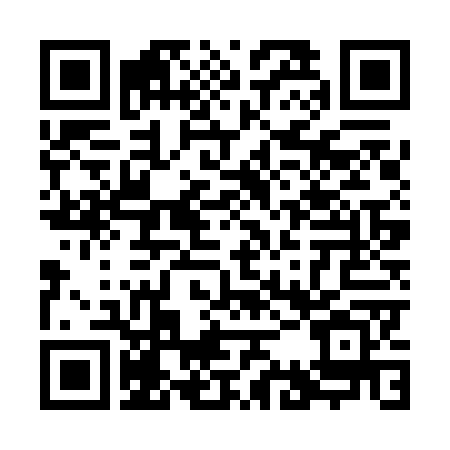
